In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from copy import copy
import tmm
import sys; sys.path.append('../../../tidy3d')
import tidy3d as td
from tidy3d.plugins.adjoint.components import JaxSimulation
from tidy3d.plugins.adjoint.web import run as run_adjoint
from tidy3d.web import run as run_web

In [7]:
def grad_tmm(freqs, theta, bck_eps, slab_eps, slab_ds):
    """Use numerical derivative to compute the gradient of transmission through slabs with respect
    to each slab permittivity and upper and lower boundary. Uses tmm to get the analytical
    transmission results.
    """
    delta = 1e-4
    grad_eps = np.zeros((len(slab_eps), len(freqs)))  # gradient of each slab's permittivity
    grad_bot = np.zeros((len(slab_eps), len(freqs)))  # gradient of shifting each slab's bottom boundary
    grad_top = np.zeros((len(slab_eps), len(freqs)))  # gradient of shifting each slab's top boundary
    T = np.zeros((len(freqs),))
    freq0 = freqs[len(freqs) // 2]

    def slab_ds_boundary(d_list, islab, dl, boundary):
        """Compute a list of slab thicknesses if the ``islab``-th slab's ``"top"`` or ``"bottom"``
        ``boundary`` is perturbed by ``dl``."""
        slab_ds_pert = copy(d_list)
        if boundary == "bottom":
            slab_ds_pert[islab] -= dl
            slab_ds_pert[islab - 1] += dl
        if boundary == "top":
            slab_ds_pert[islab] += dl
            slab_ds_pert[islab + 1] -= dl

        return slab_ds_pert

    eps_list = [bck_eps] + slab_eps + [bck_eps]
    n_list = np.sqrt(eps_list)
    d_list = [np.inf] + slab_ds + [np.inf]
    for ifreq, freq in enumerate(freqs):
        wavelength = td.C_0 / freq
        for islab in range(len(slab_eps)):
            n_list_p = n_list.copy()
            n_list_p[islab + 1] = np.sqrt(slab_eps[islab] + delta / 2)
            n_list_m = n_list.copy()
            n_list_m[islab + 1] = np.sqrt(slab_eps[islab] - delta / 2)
            d_list_p_top = slab_ds_boundary(d_list, islab + 1, delta / 2, "top")
            d_list_m_top = slab_ds_boundary(d_list, islab + 1, -delta / 2, "top")
            d_list_p_bot = slab_ds_boundary(d_list, islab + 1, delta / 2, "bottom")
            d_list_m_bot = slab_ds_boundary(d_list, islab + 1, -delta / 2, "bottom")
            
            # using a constant-k rather than constant-angle formulation, so angle is
            # frequency-dependent
            th = np.arcsin(np.sin(theta) * freq0 / freq)

            T[ifreq] = tmm.coh_tmm("p", n_list, d_list, th, wavelength)["T"]
            t_deps_p = tmm.coh_tmm("p", n_list_p, d_list, th, wavelength)["T"]
            t_deps_m = tmm.coh_tmm("p", n_list_m, d_list, th, wavelength)["T"]
            t_dd_p_top = tmm.coh_tmm("p", n_list, d_list_p_top, th, wavelength)["T"]
            t_dd_m_top = tmm.coh_tmm("p", n_list, d_list_m_top, th, wavelength)["T"]
            t_dd_p_bot = tmm.coh_tmm("p", n_list, d_list_p_bot, th, wavelength)["T"]
            t_dd_m_bot = tmm.coh_tmm("p", n_list, d_list_m_bot, th, wavelength)["T"]

            grad_eps[islab, ifreq] = (t_deps_p - t_deps_m) / delta
            grad_top[islab, ifreq] = (t_dd_p_top - t_dd_m_top) / delta
            grad_bot[islab, ifreq] = (t_dd_p_bot - t_dd_m_bot) / delta

    # Normalize gradients to sum up to 1 at every frequency
    grad_eps = grad_eps / np.linalg.norm(grad_eps, axis=0)
    grad_top = grad_top / np.linalg.norm(grad_top, axis=0)
    grad_bot = grad_bot / np.linalg.norm(grad_bot, axis=0)
        
    tmm_data = {"grad_eps": grad_eps, "grad_top": grad_top, "grad_bot": grad_bot, "T": T}
    return tmm_data

In [30]:
def run(
    freq0=2e14,
    num_freqs=101,
    subpixel=False,
    offset_z=1e-5,
    dl=0.0125,
    slab_eps=[2**2, 1.8**2, 1.5**2, 1.9**2],
    slab_ds=[0.5, 0.25, 0.5, 0.25],
    bck_eps=1.4**2,
    angle_theta = 0,
):

    # frequency setup
    wavelength = td.C_0 / freq0
    fwidth = freq0 / 10.0
    ind_freq0 = num_freqs // 2
    freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, num_freqs)

    # geometry setup
    bck_medium = td.Medium(permittivity=bck_eps)

    space_above = 2
    space_below = 2

    length_x = 0.2
    center_x = 0.0
    length_z = space_below + np.sum(slab_ds) + space_above
    sim_size = (length_x, 0, length_z)

    # make structures
    slabs = []
    z_start = -np.sum(slab_ds) / 2
    for (d, eps) in zip(slab_ds, slab_eps):
        slab = td.Structure(
            geometry=td.Box(center=[0, 0, z_start + offset_z + d / 2], size=[td.inf, td.inf, d]),
            medium=td.Medium(permittivity=eps),
        )
        slabs.append(slab)
        z_start += d

    # source setup
    gaussian = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
    src_z = -length_z / 2 + 3 * space_below / 4

    source = td.PlaneWave(
        center=(center_x, 0, src_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="+",
        angle_theta=angle_theta,
        angle_phi=0,
        pol_angle=0,
    )

    # boundaries
    boundary_x = td.Boundary.bloch_from_source(
        source=source, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_spec = td.BoundarySpec(x=boundary_x, y=td.Boundary.periodic(), z=td.Boundary.pml(num_layers=40))

    # monitors
    mnt_z = length_z / 2 - wavelength
    monitor_1 = td.DiffractionMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="diffraction",
        normal_dir="+",
    )

    monitor_2 = td.FieldMonitor(
        center=[0.0, 0.0, mnt_z],
        size=[td.inf, td.inf, 0],
        freqs=freqs,
        name="field",
    )

    # monitors to record the fields and permittivity needed for the gradient computation
    monitor_g1 = td.FieldMonitor(
        center=[0.0, 0.0, 0.0],
        size=[td.inf, td.inf, np.sum(slab_ds) + 1],
        freqs=freqs,
        name="field_grad",
    )
    monitor_g2 = td.PermittivityMonitor(
        center=[0.0, 0.0, 0.0],
        size=[td.inf, td.inf, np.sum(slab_ds) + 1],
        freqs=freqs,
        name="eps_grad",
    )

    # make simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=slabs,
        sources=[source],
        monitors=[monitor_1, monitor_2, monitor_g1, monitor_g2],
        run_time=50 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=subpixel,
        shutoff=1e-8,
    )
    # fig, ax = plt.subplots(1, 3)
    # sim.plot(y=0, ax=ax[0])

    # run forward simulation
    sim_data = run_web(sim, task_name='slab')
    
    # output amplitudes
    amps = sim_data['diffraction'].amps.sel(polarization="p").values.ravel()

    # setup and run adjoint simulation
    # source needs to be centered at the simulation center_x, not the monitor one
    source_adj = td.PlaneWave(
        center=(center_x, 0, mnt_z),
        size=(td.inf, td.inf, 0),
        source_time=gaussian,
        direction="-",
        angle_theta=angle_theta,
        angle_phi=0,
        pol_angle=0,
    )

    # adjoint boundaries (bloch vector flips sign) because of source direction = "-"
    boundary_x = td.Boundary.bloch_from_source(
        source=source_adj, domain_size=sim_size[0], axis=0, medium=bck_medium
    )
    boundary_spec = td.BoundarySpec(x=boundary_x, y=td.Boundary.periodic(), z=td.Boundary.pml(num_layers=40))
    sim_adj = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.uniform(dl=dl),
        structures=slabs,
        sources=[source_adj],
        monitors=[monitor_g1, monitor_g2],
        run_time=50 / fwidth,
        boundary_spec=boundary_spec,
        medium=bck_medium,
        subpixel=subpixel,
        shutoff=1e-8,
    )
    # sim_adj.plot(y=0, ax=ax[1])
    # plt.show()

    sim_data_adj = run_web(sim_adj, task_name='slab_adjoint')

    # compute gradient w.r.t. slab permittivity and the top of the slab boundaries
    Exf, Eyf = sim_data["field_grad"].Ex, sim_data["field_grad"].Ey
    Dzf = sim_data["field_grad"].Ez * sim_data["eps_grad"].eps_zz
    Exa, Eya = sim_data_adj["field_grad"].Ex, sim_data_adj["field_grad"].Ey
    Dza = sim_data_adj["field_grad"].Ez * sim_data_adj["eps_grad"].eps_zz
    eps_list = [bck_eps] + slab_eps + [bck_eps]
    
    Nx = 100
    Nz = 100
    dx = length_x / Nx
    xs = np.linspace(-length_x / 2 + dx/2, length_x / 2 - dx/2, 100)

    zs = sim_data["field_grad"].Ex.z

    grad_top_adj = []
    grad_eps_adj = []

    for islab, slab in enumerate(slabs):
        """epsilon gradient"""
        # zinds = np.where((zs > slab.geometry.bounds[0][2]) * (zs < slab.geometry.bounds[1][2]))[0]
        # e_fwd = np.stack(
        #     (
        #         sim_data["field_grad"].Ex.isel(x=slice(1, -1), z=zinds),
        #         sim_data["field_grad"].Ey.isel(x=slice(1, -1), z=zinds),
        #         sim_data["field_grad"].Ez.isel(x=slice(1, -1), z=zinds),
        #     ),
        #     axis=0,
        # )
        # e_adj = np.stack(
        #     (
        #         sim_data_adj["field_grad"].Ex.isel(x=slice(1, -1), z=zinds),
        #         sim_data_adj["field_grad"].Ey.isel(x=slice(1, -1), z=zinds),
        #         sim_data_adj["field_grad"].Ez.isel(x=slice(1, -1), z=zinds),
        #     ),
        #     axis=0,
        # )
        
        zmin, zmax = slab.geometry.bounds[0][2], slab.geometry.bounds[1][2]
        dz = (zmax - zmin) / Nz
        zs = np.linspace(zmin+dz/2, zmax-dz/2, Nz)

        e_fwd = np.stack(
            (
                sim_data["field_grad"].Ex.interp(x=xs, z=zs),
                sim_data["field_grad"].Ey.interp(x=xs, z=zs),
                sim_data["field_grad"].Ez.interp(x=xs, z=zs),
            ),
            axis=0,
        )
        e_adj = np.stack(
            (
                sim_data_adj["field_grad"].Ex.interp(x=xs, z=zs),
                sim_data_adj["field_grad"].Ey.interp(x=xs, z=zs),
                sim_data_adj["field_grad"].Ez.interp(x=xs, z=zs),
            ),
            axis=0,
        )
        
        grad = dz * dx * np.sum(e_fwd * e_adj, axis=(0, 1, 2, 3)) # shape (nfreqs)
        # The 1j * np.conj(amps) due to dL/dE_fwd comes in here
        grad_eps_adj.append(grad * 1j * np.conj(amps))

        """top boundary gradient"""
        z_top = slab.geometry.bounds[1][2]
        d_eps = eps_list[islab + 1] - eps_list[islab + 2]
        d_eps_inv = (1 / eps_list[islab + 1] - 1 / eps_list[islab + 2])

        ex_fwd = Exf.interp(x=xs, z=z_top)
        ex_adj = Exa.interp(x=xs, z=z_top) 
        ey_fwd = Eyf.interp(x=xs, z=z_top) 
        ey_adj = Eya.interp(x=xs, z=z_top)
        dz_fwd = Dzf.interp(x=xs, z=z_top) 
        dz_adj = Dza.interp(x=xs, z=z_top) 

        integrand = d_eps * (ex_fwd * ex_adj + ey_fwd * ey_adj)
    #     print(float(np.real(integrand.isel(x=0)*1j*np.conj(amps))))
    #     print(float(np.real((d_eps_inv * (dz_fwd * dz_adj)).isel(x=0)*1j*np.conj(amps))))
        integrand -= d_eps_inv * (dz_fwd * dz_adj)

        grad = integrand.sum(dim=["x", "y"]) # shape (nfreqs)
        # The 1j * np.conj(amps) due to dL/dE_fwd comes in here
        grad_top_adj.append(grad * 1j * np.conj(amps))

    g_eps_adj = np.real(grad_eps_adj)
    grad_eps_adj = g_eps_adj / np.linalg.norm(g_eps_adj, axis=0)
    # print(grad_eps_adj)

    g_top_adj = np.real(grad_top_adj)
    grad_top_adj = g_top_adj / np.linalg.norm(g_top_adj, axis=0)
    # print(grad_top_adj)

    # compute numerical gradient
    tmm_data = grad_tmm(freqs, angle_theta, bck_eps, slab_eps, slab_ds)
    grad_eps = tmm_data["grad_eps"]
    grad_top = tmm_data["grad_top"]

    # print(grad_eps)

    # for p in 2 * np.pi * np.linspace(-1, 1, 2001):
    #     g_phased = np.real(np.array(grad_eps_adj) * np.exp(1j * p))
    #     g_phased /= np.linalg.norm(g_phased)
    #     diff = np.linalg.norm(g_phased - grad_eps)
    #     if diff < 0.1:
    #         print(p / 2 / np.pi, g_phased, diff)

    print("Difference in epsilon gradient: ", np.linalg.norm(grad_eps - grad_eps_adj, axis=0))
    print("Difference in top boundary gradient: ", np.linalg.norm(grad_top - grad_top_adj, axis=0))
    
    grad_data = {"eps": grad_eps_adj, "top": grad_top_adj}
    
    return sim_data, sim_data_adj, grad_data, tmm_data



In [31]:
def plot_grad_eps(sim_data, grad_eps_adj, grad_eps):
    freqs = sim_data["diffraction"].amps.f
    amps = sim_data["diffraction"].amps.sel(polarization="p").values.ravel()
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for islab in range(0, 4):
        ax[0].plot(freqs, grad_eps_adj[islab], color=colors[islab + 1])
    for islab in range(0, 4):
        ax[0].plot(freqs, grad_eps[islab], color=colors[islab + 1], linestyle="dashed")
    ax[0].set_xlabel("frequency")
    ax[0].set_ylabel("Gradient (adjoint/numerical)")
    ax[0].legend(["slab 1", "slab 2", "slab 3", "slab 4"])

    for islab in range(0, 4):
        ax[1].plot(freqs, np.abs((grad_eps - grad_eps_adj)[islab]**2), color=colors[islab+1])
    ax[1].set_xlabel("frequency")
    ax[1].set_ylabel("Gradient error")
    ax[1].legend(["slab 1", "slab 2", "slab 3", "slab 4"])

    ax[2].plot(freqs, np.abs(amps), color="k")
    ax[2].plot(freqs, np.real(amps))
    ax[2].plot(freqs, np.imag(amps))
    ax[2].set_xlabel("frequency")
    ax[2].set_ylabel("Transmission")
    ax[2].legend(["abs", "re", "im"])
    
def plot_grad_top(sim_data, grad_top_adj, grad_top):
    freqs = sim_data["diffraction"].amps.f
    amps = sim_data["diffraction"].amps.sel(polarization="p").values.ravel()
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for islab in range(0, 4):
        ax[0].plot(freqs, grad_top_adj[islab], color=colors[islab + 1])
    for islab in range(0, 4):
        ax[0].plot(freqs, grad_top[islab], color=colors[islab + 1], linestyle="dashed")
    ax[0].set_xlabel("frequency")
    ax[0].set_ylabel("Gradient (adjoint/numerical)")
    ax[0].legend(["slab 1", "slab 2", "slab 3", "slab 4"])

    for islab in range(0, 4):
        ax[1].plot(freqs, np.abs((grad_top - grad_top_adj)[islab]**2), color=colors[islab+1])
    ax[1].set_xlabel("frequency")
    ax[1].set_ylabel("Gradient error")
    ax[1].legend(["slab 1", "slab 2", "slab 3", "slab 4"])

    ax[2].plot(freqs, np.abs(amps), color="k")
    ax[2].plot(freqs, np.real(amps))
    ax[2].plot(freqs, np.imag(amps))
    ax[2].set_xlabel("frequency")
    ax[2].set_ylabel("Transmission")
    ax[2].legend(["abs", "re", "im"])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 28.7/28.7 MB • 2.3 MB/s • 0:00:00

[11:37:06] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=891373;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=657203;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Difference in epsilon gradient:  [0.02644031 0.02655231 0.02666716 0.0267798  0.02687666 0.02697693
 0.02707061 0.02716638 0.02725343 0.02734792 0.02742618 0.02748405
 0.02754759 0.02760828 0.02765968 0.02770093 0.02774415 0.02776657
 0.02778225 0.02775525 0.02774513 0.02770698 0.02765789 0.02759046
 0.02749916 0.02738026 0.02720303 0.02702462 0.02680738 0.02656472
 0.02627418 0.02594195 0.02556252 0.02510783 0.02464243 0.02413025
 0.02359847 0.02304591 0.02247409 0.02192665 0.02140485 0.02101447
 0.02077746 0.02076892 0.02103894 0.02163318 0.02259257 0.02392076
 0.02561941 0.02763589 0.02991751 0.03239406 0.03501136 0.0377041
 0.04042573 0.04308194 0.04563696 0.04806432 0.0503186  0.05238514
 0.05424275 0.05591596 0.057345   0.05854387 0.05954189 0.0603526
 0.06098209 0.06144993 0.06179283 0.0619805  0.06205249 0.06202174
 0.06191094 0.06173055 0.06148709 0.06121317 0.06088105 0.06051612
 0.06011986 0.05971345 0.05929458 0.05886444 0.05844299 0.05800491
 0.05756732 0.05713252 0.056706

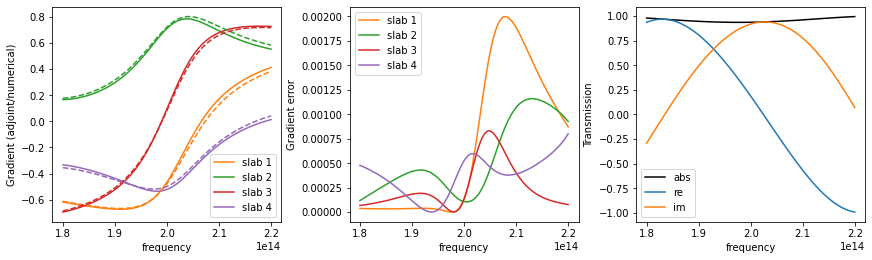

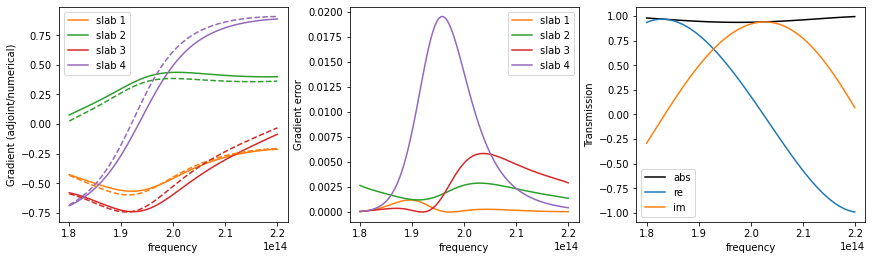

In [32]:
sim_data, sim_data_adj, grad_data, tmm_data = run()
plot_grad_eps(sim_data, grad_data["eps"], tmm_data["grad_eps"])
plot_grad_top(sim_data, grad_data["top"], tmm_data["grad_top"])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 97.3% • 27.9/28.7 MB • 10.3 MB/s • 0:00:01

[11:38:59] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=530472;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=47392;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Difference in epsilon gradient:  [0.00695932 0.00678216 0.00662115 0.0064806  0.00638152 0.00628772
 0.00621331 0.00614363 0.00609349 0.00603921 0.00601093 0.00601351
 0.00601022 0.00600993 0.00602051 0.00604261 0.00605773 0.00609387
 0.00613162 0.00621211 0.0062608  0.0063302  0.00639659 0.00646681
 0.00654349 0.00662827 0.00674818 0.00684237 0.00694388 0.0070367
 0.0071392  0.0072431  0.00735159 0.00748778 0.00758995 0.00769562
 0.00778154 0.00785663 0.00793697 0.00800084 0.0080835  0.00811524
 0.00812898 0.00810636 0.00804887 0.00798265 0.0078797  0.00779056
 0.00762406 0.00739894 0.00715763 0.00685227 0.00653231 0.0061895
 0.00585595 0.00544744 0.00500505 0.00456616 0.00410473 0.00364951
 0.00318859 0.00279071 0.0023561  0.00190951 0.00148706 0.00109576
 0.00073303 0.00043747 0.0003343  0.00049832 0.00076809 0.00105869
 0.00133669 0.00159796 0.00185415 0.00206048 0.00229248 0.00251821
 0.00274921 0.0029553  0.00315607 0.00335985 0.00353021 0.00373286
 0.00393978 0.00414968 0.004355

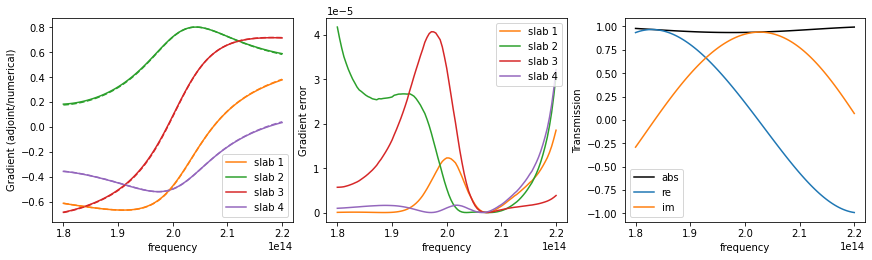

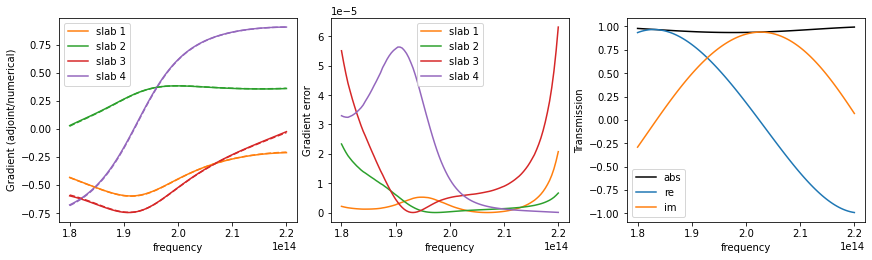

In [33]:
# subpixel = True degrades eps gradient but improves moving boundaries
sim_data, sim_data_adj, grad_data, tmm_data = run(subpixel=True)
plot_grad_eps(sim_data, grad_data["eps"], tmm_data["grad_eps"])
plot_grad_top(sim_data, grad_data["top"], tmm_data["grad_top"])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.1% • 28.4/28.7 MB • 2.2 MB/s • 0:00:01

[11:40:49] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=791744;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=411421;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Difference in epsilon gradient:  [0.02338847 0.02371565 0.02416958 0.02473539 0.02541826 0.0261814
 0.02702983 0.02794691 0.02894297 0.02999356 0.03112588 0.03234551
 0.03361956 0.03495866 0.03637163 0.0378614  0.03941328 0.04105661
 0.04277827 0.04462    0.04651273 0.04851188 0.05059684 0.05277919
 0.05506445 0.05745669 0.0599876  0.06259341 0.0653105  0.06812269
 0.07104612 0.07406912 0.07719011 0.08042823 0.0837036  0.08704466
 0.09040757 0.09378362 0.097161   0.10049237 0.10377649 0.1069021
 0.10985988 0.11258775 0.11504091 0.11718821 0.11896989 0.12037771
 0.12128331 0.12167435 0.12156559 0.12089916 0.11972033 0.11803076
 0.11588698 0.11322939 0.11014972 0.10672135 0.10298472 0.09901988
 0.09487488 0.09066364 0.08635276 0.08201439 0.0777248  0.07352861
 0.06944902 0.06552261 0.06180526 0.05824909 0.05490878 0.05178701
 0.04891157 0.04628442 0.04390798 0.04181049 0.03994944 0.03834729
 0.0369988  0.03591398 0.03508051 0.03449036 0.03414098 0.03401218
 0.03409925 0.03439506 0.034887

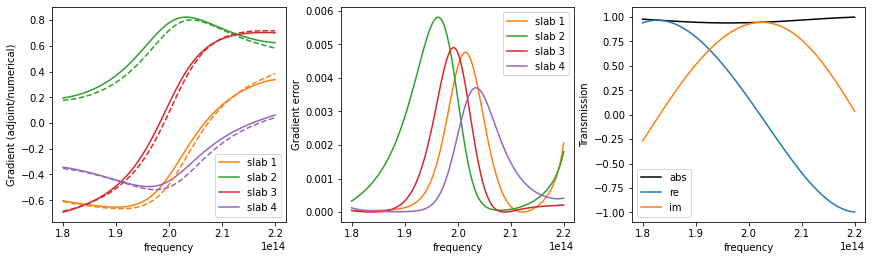

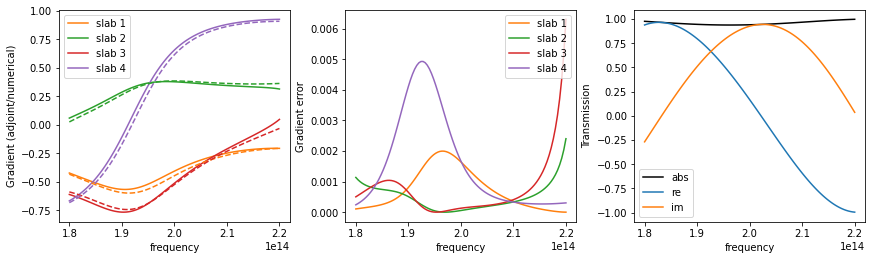

In [34]:
# offset_z = 0 degrades eps gradient but also improves moving boundaries a little
sim_data, sim_data_adj, grad_data, tmm_data = run(offset_z=0)
plot_grad_eps(sim_data, grad_data["eps"], tmm_data["grad_eps"])
plot_grad_top(sim_data, grad_data["top"], tmm_data["grad_top"])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 28.7/28.7 MB • 2.4 MB/s • 0:00:00

[11:42:37] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=350946;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14780;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Difference in epsilon gradient:  [0.03864839 0.03893544 0.03926066 0.03963663 0.04008298 0.04059728
 0.04120289 0.04190756 0.04275136 0.0437467  0.04496921 0.04647941
 0.04835007 0.05071167 0.05375943 0.05778536 0.06320813 0.07073644
 0.08125501 0.09549033 0.11111784 0.11715413 0.10421898 0.08388181
 0.06728138 0.05585588 0.04824162 0.04311596 0.03961821 0.03719228
 0.0354829  0.03426266 0.03338047 0.03272845 0.03226281 0.03192055
 0.03167851 0.03150811 0.03138823 0.03131062 0.03125563 0.03123915
 0.03124448 0.03127211 0.03131617 0.0313693  0.03143099 0.03148967
 0.03156881 0.03166464 0.03176051 0.03187327 0.03198384 0.03209781
 0.03220069 0.03232798 0.03246393 0.03259655 0.03273697 0.03287183
 0.03301032 0.03311532 0.03323893 0.03337154 0.03349171 0.03359505
 0.03368165 0.03374775 0.03375427 0.03376642 0.03374352 0.03369106
 0.03357248 0.0333954  0.03315884 0.03278523 0.03238994 0.03191352
 0.03137541 0.03072009 0.02999017 0.02921094 0.02833267 0.02753929
 0.02681895 0.02623851 0.0258

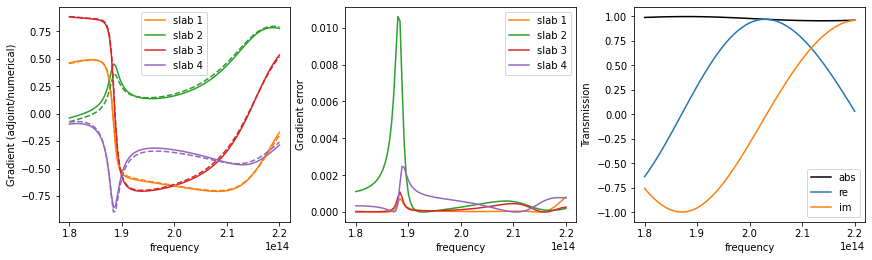

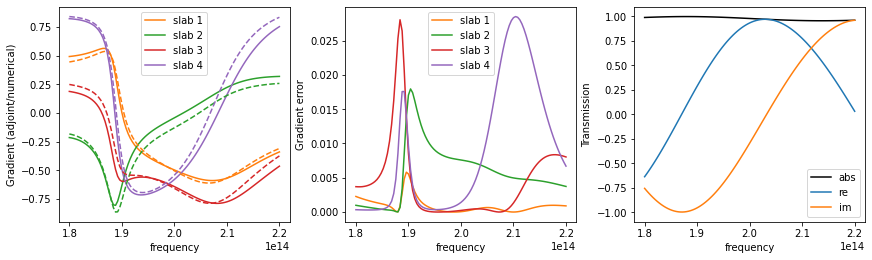

In [35]:
# add a 30 degree angle
sim_data, sim_data_adj, grad_data, tmm_data = run(angle_theta=np.pi / 6)
plot_grad_eps(sim_data, grad_data["eps"], tmm_data["grad_eps"])
plot_grad_top(sim_data, grad_data["top"], tmm_data["grad_top"])

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 99.1% • 28.4/28.7 MB • 1.4 MB/s • 0:00:01

[11:44:27] INFO     loading SimulationData from simulation_data.hdf5                                  ]8;id=947835;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=458964;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/source/notebooks/../../../tidy3d/tidy3d/web/webapi.py#407\407]8;;\

Difference in epsilon gradient:  [0.00806111 0.00809999 0.00814686 0.00821407 0.00835773 0.00850583
 0.00870143 0.008917   0.00920617 0.00951102 0.00993881 0.01052467
 0.01121241 0.01206148 0.0131694  0.01465639 0.01662808 0.01953654
 0.02387724 0.03097398 0.03997471 0.04599859 0.04047008 0.02997993
 0.02178859 0.01644021 0.013107   0.01065465 0.00891314 0.00758786
 0.00659676 0.00582378 0.00522208 0.00478846 0.00437915 0.00405678
 0.00377289 0.00353768 0.00335351 0.00320136 0.00310253 0.00299569
 0.00290816 0.00282902 0.00276149 0.00271384 0.00267947 0.00267195
 0.00265249 0.00262715 0.00261668 0.00259748 0.00259184 0.00259069
 0.00260694 0.00260405 0.00259763 0.00259777 0.0025929  0.00259349
 0.00259006 0.00260709 0.0026067  0.00259512 0.00258513 0.0025774
 0.00256951 0.00256182 0.00256622 0.00255921 0.00255581 0.00255794
 0.00257434 0.00260563 0.00265729 0.00272184 0.00282479 0.00296744
 0.00316452 0.00339373 0.00366994 0.00400067 0.00432248 0.00474476
 0.00521278 0.00572276 0.00623

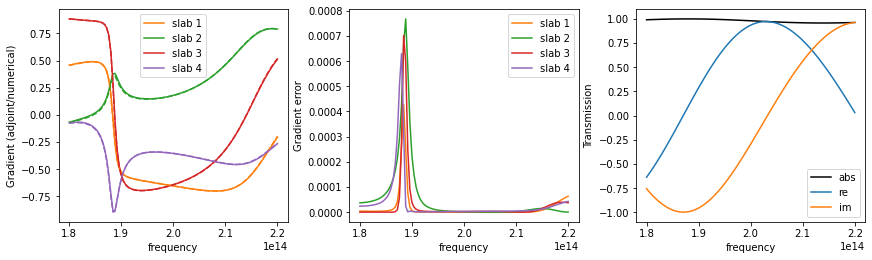

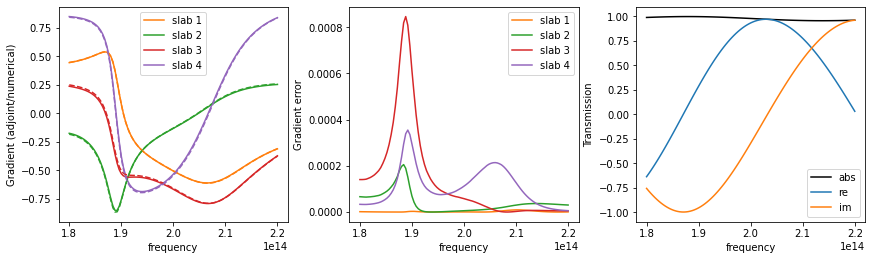

In [36]:
# angled incidence with subpixel actually *better* for both!
sim_data, sim_data_adj, grad_data, tmm_data = run(angle_theta=np.pi / 6, subpixel=True)
plot_grad_eps(sim_data, grad_data["eps"], tmm_data["grad_eps"])
plot_grad_top(sim_data, grad_data["top"], tmm_data["grad_top"])